# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [40]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [41]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [42]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
azdias.head()

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [43]:
print(feat_info.shape)
feat_info.head()

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [44]:
# Identify missing or unknown data values and convert them to NaNs.

# Identify naturally missing data porcentage
element_count = 0
for i in azdias.count():
    element_count = element_count + i
print ("Naturally missing data porcentage is {} %".format(100*(1-element_count/azdias.size)))

Naturally missing data porcentage is 6.464149613118342 %


In [45]:
# Method to obtain list of 'missing' or 'unknown'
def create_x_list(x):
    x = x.strip('[]')
    x_list = x.split(",")
    i = 0
    for value in x_list:
        if(is_integer(value)):
            x_list[i] = int(x_list[i]) 
        i = i + 1
    x_list=[item for item in x_list if item != '']
    return x_list

In [46]:
# Method to check if value is integer
def is_integer(value):
    try:
        int(value)
        return True
    except:
        return False

In [47]:
# Convert data that matches a 'missing' or 'unknown' value code into NaN
for column in azdias:
    tmp = feat_info.loc[(feat_info['attribute'] == column)]['missing_or_unknown']
    for item in tmp:
        x_list = create_x_list(item)
    for element in x_list:
        azdias.loc[azdias[column] == element, column] = np.NAN

In [48]:
# Identify missing data porcentage after replacing 'missing' or 'unknown' value codes
element_count = 0
for i in azdias.count():
    element_count = element_count + i
print ("Missing data porcentage is {} %".format(100*(1-element_count/azdias.size)))

Missing data porcentage is 11.054139407027652 %


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [49]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Create dictionary of number of NaN elements for each column
nan_dict = {}
i=0
for column in azdias:
    #print("column {}".format(i))
    nan_count = len(azdias[column])-azdias[column].count()
    nan_dict.update({column:nan_count})
    i=i+1
#print(nan_dict)

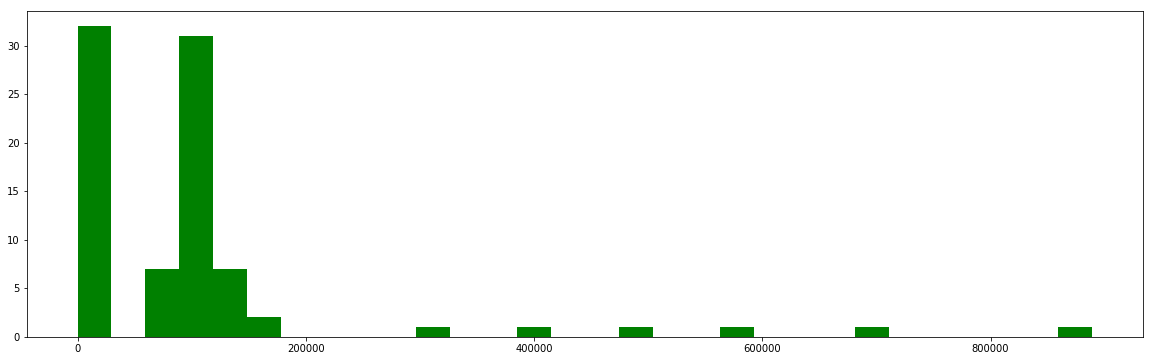

In [50]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(20,6))
plt.hist(nan_dict.values(), color='g',bins=30)
plt.show()

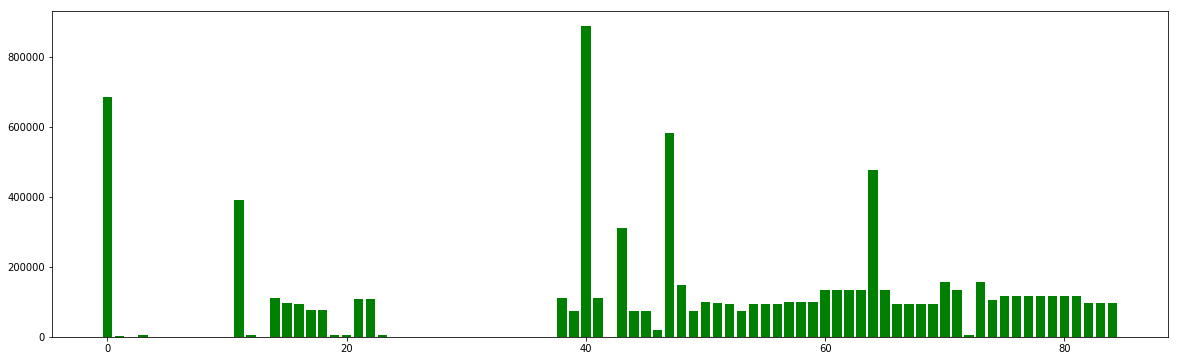

In [51]:
# Print number of missing values per column
plt.figure(figsize=(20,6))
x=range(0,azdias.shape[1])
plt.bar(x,nan_dict.values(), color='g')
plt.show()

In [52]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

cols=[]
for key in nan_dict.keys():
    if nan_dict[key]>200000:
        cols.append(key)
print(cols)
azdias.drop(cols,axis=1,inplace=True)
azdias.head()

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

As it could be observed in the previous histogram, the percentage of missing data is less than 15% in almost all columns.
However, it was noticed that six columns('AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX') showed an extremely high percentage of missing values. These columns are treated as outliers(dropped from the dataset).
Furthermore the following patterns were found in the data:
- KKK REGIOTYP columns had the same amount of missing values (both related to region)
- KBA05_ANTG1 KBA05_ANTG2 KBA05_ANTG3 KBA05_ANTG4 KBA05_GBZ MOBI_REGIO columns had the same amount of missing values (all related to living place)
- PLZ8_ANTG1 PLZ8_ANTG2 PLZ8_ANTG3 PLZ8_ANTG4 PLZ8_BAUMAX PLZ8_GBZ PLZ8_HHZ columns had the same amount of missing values (all related to PLZ8 region living place info)
- HEALTH_TYP SHOPPER_TYP VERS_TYP columns had the same amount of missing values (related to health/shopping)
- CAMEO_DEUG_2015 CAMEO_DEU_2015 CAMEO_INTL_2015 columns had the same amount of missing values (related to micro-cell features)
- ARBEIT RELAT_AB columns had the same amount of missing values (related to employment)
- BALLRAUM EWDICHTE INNENSTADT columns had the same amount of missing values (related to postcode-level features)
- GEBAEUDETYP MIN_GEBAEUDEJAHR OST_WEST_KZ WOHNLAGE columns had the same amount of missing values (related to building/neighborhood)
- LP_FAMILIE_FEIN LP_FAMILIE_GROB columns had the same amount of missing values (related to family)
- ANZ_PERSONEN ANZ_TITEL SOHO_KZ WOHNDAUER_2008 columns had the same amount of missing values (related to household information)
- CJT_GESAMTTYP GFK_URLAUBERTYP LP_STATUS_FEIN LP_STATUS_GROB ONLINE_AFFINITAET RETOURTYP_BK_S columns had the same amount of missing values (related to consumer habits and social status)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

In [53]:
# How much data is missing in each row of the dataset?

# Create list of number of NaN elements for each row
nan_list = []
rows=azdias.shape[0]
columns=azdias.shape[1]
for i in range(0,rows):
    nan_count = columns-azdias.loc[i].count()
    nan_list.append(nan_count)
#print(nan_list)

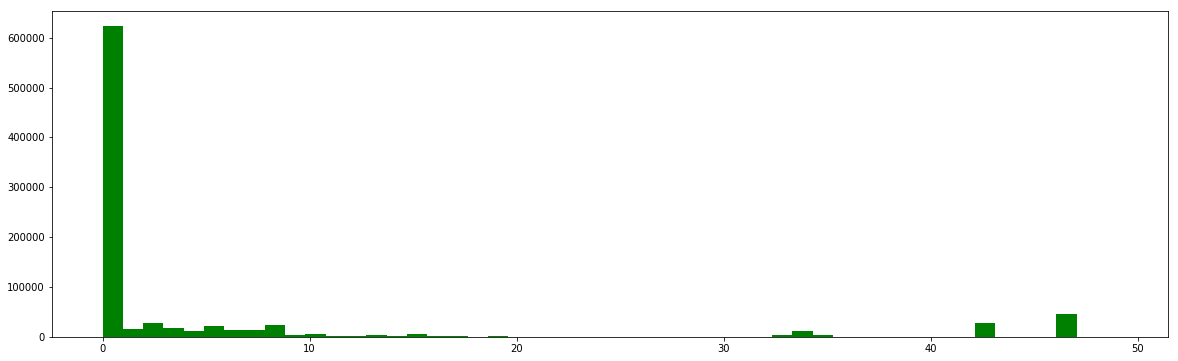

In [54]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Plotting histogram of missing values per row
plt.figure(figsize=(20,6))
plt.hist(nan_list, color='g',bins=50)
plt.show()

In [55]:
# Find row numbers to be separated (divided)
# Threshold: more than 20 missing elements
i=0
nan_list_row=[]
for element in nan_list:
    if(element>20):
        nan_list_row.append(i)
    i = i + 1
#print(nan_list_row)

In [56]:
# Divide dataframe
azdias_nan_subset = pd.DataFrame(columns=azdias.columns)
azdias_nan_subset = azdias_nan_subset.append(azdias.loc[nan_list_row],ignore_index=True)
#azdias_nan_subset.shape

azdias.drop(nan_list_row,inplace=True)
#azdias.shape

In [57]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Function to plot values
def compare_col_hist(col):
    fig, axs = plt.subplots(1, 2, tight_layout=True)
    azdias.hist(column=col,bins=50,ax=axs[0])
    azdias_nan_subset.hist(column=col,bins=50,ax=axs[1])

ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GREEN_AVANTGARDE
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
ZABEOTYP


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


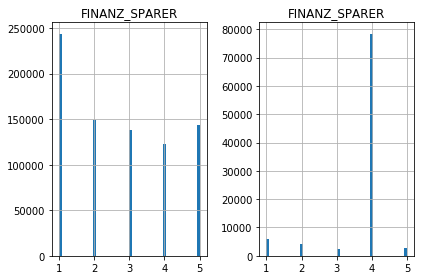

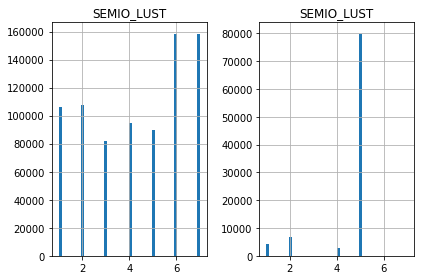

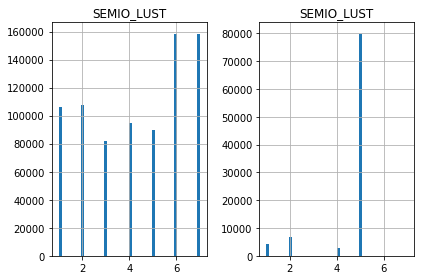

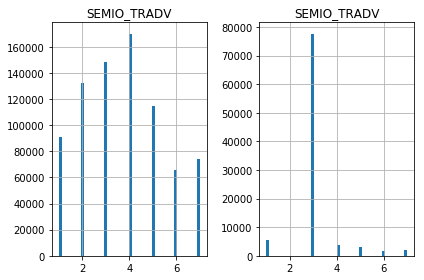

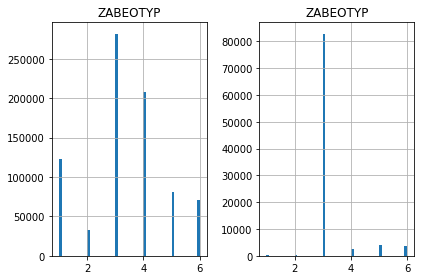

In [58]:
# Plot and compare

# Find columns with no nan-elements
i=0
for col in nan_dict.keys():
    if(nan_dict[col]==0):
        print(col)
    i = i + 1
        
pick_columns = ['FINANZ_SPARER','SEMIO_LUST','SEMIO_LUST','SEMIO_TRADV','ZABEOTYP']
for col in pick_columns:
    compare_col_hist(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

After plotting the number of missing values per row, it could be noticed that most rows had less that 20 missing values.
Some rows had more than 20 missing values (those rows are treated as outliers).
After dividing the data based on this threshold (20 values missing per row), and comparing the column value distribution for columns with zero missing values(5 samples), it could be noticed that:
- All columns had different distributions. Special treatment may be required for these columns

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [59]:
# How many features are there of each data type?

feat_info.groupby(['type']).size()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [60]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

feat_info[feat_info['type']=='categorical']
#azdias[azdias.columns[53]]

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [61]:
# Re-encode categorical variable(s) to be kept in the analysis.

categorical_cols = []
for a in feat_info[feat_info['type']=='categorical']['attribute']:
    categorical_cols.append(a)
    
for cols in azdias.columns:
    if cols in categorical_cols:
        if len(azdias[cols].unique()) > 2:
            azdias = azdias.drop(cols, axis=1)
            print("more than 2 categories: {}".format(cols))
        else:
            if(not is_integer(azdias[cols].unique()[0])):
                dummies = pd.get_dummies(azdias[cols],prefix=cols)
                azdias = azdias.drop(cols, axis=1)
                azdias = azdias.join(dummies)
                print("transformed by get_dummies: {}".format(cols))

more than 2 categories: CJT_GESAMTTYP
more than 2 categories: FINANZTYP
more than 2 categories: GFK_URLAUBERTYP
more than 2 categories: LP_FAMILIE_FEIN
more than 2 categories: LP_FAMILIE_GROB
more than 2 categories: LP_STATUS_FEIN
more than 2 categories: LP_STATUS_GROB
more than 2 categories: NATIONALITAET_KZ
more than 2 categories: SHOPPER_TYP
more than 2 categories: VERS_TYP
more than 2 categories: ZABEOTYP
more than 2 categories: GEBAEUDETYP
transformed by get_dummies: OST_WEST_KZ
more than 2 categories: CAMEO_DEUG_2015
more than 2 categories: CAMEO_DEU_2015


#### Discussion 1.2.1: Re-Encode Categorical Features

feat_info has 21 categorical features. Out of them, 18 were present in our dataframe(the other three were previosuly deleted for having too many missing values). The categorical features with more than 3 values were deleted for simplicity. The binary categories were left untouched, except by OST_WEST_KZ. OST_WEST_KZ which was one-hot-encoded using get_dummies.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [62]:
feat_info[feat_info['type']=='mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [63]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

PRAEGENDE_JUGENDJAHRE_new = azdias[['PRAEGENDE_JUGENDJAHRE', 'PRAEGENDE_JUGENDJAHRE']].copy()
PRAEGENDE_JUGENDJAHRE_new.columns = ['PRAEGENDE_JUGENDJAHRE_DECADE','PRAEGENDE_JUGENDJAHRE_MOVEMENT']

#Set Decade
PRAEGENDE_JUGENDJAHRE_new.loc[PRAEGENDE_JUGENDJAHRE_new['PRAEGENDE_JUGENDJAHRE_DECADE'].isin([1,2]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 40.
PRAEGENDE_JUGENDJAHRE_new.loc[PRAEGENDE_JUGENDJAHRE_new['PRAEGENDE_JUGENDJAHRE_DECADE'].isin([3,4]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 50.
PRAEGENDE_JUGENDJAHRE_new.loc[PRAEGENDE_JUGENDJAHRE_new['PRAEGENDE_JUGENDJAHRE_DECADE'].isin([5,6,7]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 60.
PRAEGENDE_JUGENDJAHRE_new.loc[PRAEGENDE_JUGENDJAHRE_new['PRAEGENDE_JUGENDJAHRE_DECADE'].isin([8,9]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 70.
PRAEGENDE_JUGENDJAHRE_new.loc[PRAEGENDE_JUGENDJAHRE_new['PRAEGENDE_JUGENDJAHRE_DECADE'].isin([10,11,12,13]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 80.
PRAEGENDE_JUGENDJAHRE_new.loc[PRAEGENDE_JUGENDJAHRE_new['PRAEGENDE_JUGENDJAHRE_DECADE'].isin([14,15]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 90.

#Set Movement
PRAEGENDE_JUGENDJAHRE_new.loc[PRAEGENDE_JUGENDJAHRE_new['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].isin([1,3,5,8,10,12,14]), 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = 0.
PRAEGENDE_JUGENDJAHRE_new.loc[PRAEGENDE_JUGENDJAHRE_new['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].isin([2,4,6,7,9,11,13,15]), 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = 1. 

#Join Columns
azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
azdias = azdias.join(PRAEGENDE_JUGENDJAHRE_new)

In [64]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

CAMEO_INTL_2015_new = azdias[['CAMEO_INTL_2015', 'CAMEO_INTL_2015']].copy()
CAMEO_INTL_2015_new.columns = ['CAMEO_INTL_2015_WEALTH','CAMEO_INTL_2015_LIFE_STAGE']

#Set Wealth
CAMEO_INTL_2015_new['CAMEO_INTL_2015_WEALTH'] = round((CAMEO_INTL_2015_new['CAMEO_INTL_2015_WEALTH'].astype(float))/10)

#Set Life Stage
CAMEO_INTL_2015_new['CAMEO_INTL_2015_LIFE_STAGE'] = (CAMEO_INTL_2015_new['CAMEO_INTL_2015_LIFE_STAGE'].astype(float))%10

#Join Columns
azdias = azdias.drop('CAMEO_INTL_2015', axis=1)
azdias = azdias.join(CAMEO_INTL_2015_new)

In [65]:
# Dropping the remaining 5 features (KBA05_BAUMAX already dropped)

mixed_remaining_featues = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']
azdias.drop(mixed_remaining_featues,axis=1,inplace=True)
#azdias.head()

#### Discussion 1.2.2: Engineer Mixed-Type Features

There are 7 mixed variables according to feat_info. 2 of them were re-engineered and the remaining 5 were dropped:
- Two variables (PRAEGENDE_JUGENDJAHRE_MOVEMENT and PRAEGENDE_JUGENDJAHRE_DECADE) were created from the original PRAEGENDE_JUGENDJAHRE column based on Data_Dictionary.md
- Two variables (CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFE_STAGE) were created from the original CAMEO_INTL_2015 column based on Data_Dictionary.md

The remaining 5 variables were dropped folowwing the next criteria:
- LP_LEBENSPHASE_FEIN LP_LEBENSPHASE_GROB WOHNLAGE : information provided by this features can be found in CAMEO_INTL_2015
- PLZ8_BAUMAX : information provided by this features can be found in other PLZ8 macro-cell features
- KBA05_BAUMAX : this feature was already dropped in the previous step

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [66]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# No more tasks needed

In [67]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Check columns
azdias.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
       'ORTSGR_KLS9', 'RELAT_A

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [68]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for column in df:
        tmp = feat_info.loc[(feat_info['attribute'] == column)]['missing_or_unknown']
        for item in tmp:
            x_list = create_x_list(item)
        for element in x_list:
            df.loc[df[column] == element, column] = np.NAN
    
    # remove selected columns and rows, ...
    rows=df.shape[0]
    columns=df.shape[1]
    cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    #cols = []
    #for column in df:
    #    nan_count = columns-df[column].count()
    #    if(nan_count>200000):
    #        cols.append(column)
    df.drop(cols,axis=1,inplace=True)
    
    rs = []
    for row in range(0,rows):
        nan_count = columns-df.loc[row].count()
        if(nan_count>20):
            rs.append(row)
    df.drop(rs,inplace=True)
    
    # select, re-encode, and engineer column values.
    # caterical values
    categorical_cols = []
    for a in feat_info[feat_info['type']=='categorical']['attribute']:
        categorical_cols.append(a)
    for cols in df.columns:
        if cols in categorical_cols:
            if len(df[cols].unique()) > 2:
                df = df.drop(cols, axis=1)
            else:
                if(not is_integer(df[cols].unique()[0])):
                    dummies = pd.get_dummies(df[cols],prefix=cols)
                    df = df.drop(cols, axis=1)
                    df = df.join(dummies)
    
    # mixed values
    #"PRAEGENDE_JUGENDJAHRE" 
    PRAEGENDE_JUGENDJAHRE_new = df[['PRAEGENDE_JUGENDJAHRE', 'PRAEGENDE_JUGENDJAHRE']].copy()
    PRAEGENDE_JUGENDJAHRE_new.columns = ['PRAEGENDE_JUGENDJAHRE_DECADE','PRAEGENDE_JUGENDJAHRE_MOVEMENT']
    PRAEGENDE_JUGENDJAHRE_new.loc[PRAEGENDE_JUGENDJAHRE_new['PRAEGENDE_JUGENDJAHRE_DECADE'].isin([1,2]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 40.
    PRAEGENDE_JUGENDJAHRE_new.loc[PRAEGENDE_JUGENDJAHRE_new['PRAEGENDE_JUGENDJAHRE_DECADE'].isin([3,4]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 50.
    PRAEGENDE_JUGENDJAHRE_new.loc[PRAEGENDE_JUGENDJAHRE_new['PRAEGENDE_JUGENDJAHRE_DECADE'].isin([5,6,7]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 60.
    PRAEGENDE_JUGENDJAHRE_new.loc[PRAEGENDE_JUGENDJAHRE_new['PRAEGENDE_JUGENDJAHRE_DECADE'].isin([8,9]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 70.
    PRAEGENDE_JUGENDJAHRE_new.loc[PRAEGENDE_JUGENDJAHRE_new['PRAEGENDE_JUGENDJAHRE_DECADE'].isin([10,11,12,13]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 80.
    PRAEGENDE_JUGENDJAHRE_new.loc[PRAEGENDE_JUGENDJAHRE_new['PRAEGENDE_JUGENDJAHRE_DECADE'].isin([14,15]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 90.
    PRAEGENDE_JUGENDJAHRE_new.loc[PRAEGENDE_JUGENDJAHRE_new['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].isin([1,3,5,8,10,12,14]), 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = 0.
    PRAEGENDE_JUGENDJAHRE_new.loc[PRAEGENDE_JUGENDJAHRE_new['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].isin([2,4,6,7,9,11,13,15]), 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = 1. 
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    df = df.join(PRAEGENDE_JUGENDJAHRE_new)
    
    #CAMEO_INTL_2015
    CAMEO_INTL_2015_new = df[['CAMEO_INTL_2015', 'CAMEO_INTL_2015']].copy()
    CAMEO_INTL_2015_new.columns = ['CAMEO_INTL_2015_WEALTH','CAMEO_INTL_2015_LIFE_STAGE']
    CAMEO_INTL_2015_new['CAMEO_INTL_2015_WEALTH'] = round((CAMEO_INTL_2015_new['CAMEO_INTL_2015_WEALTH'].astype(float))/10)
    CAMEO_INTL_2015_new['CAMEO_INTL_2015_LIFE_STAGE'] = (CAMEO_INTL_2015_new['CAMEO_INTL_2015_LIFE_STAGE'].astype(float))%10
    df = df.drop('CAMEO_INTL_2015', axis=1)
    df = df.join(CAMEO_INTL_2015_new)
    
    #Remaining mixed-type features
    mixed_remaining_featues = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']
    df = df.drop(mixed_remaining_featues,axis=1)

    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [69]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.

# Applying Imputer

fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
azdias_imputed = pd.DataFrame(fill_NaN.fit_transform(azdias))
azdias_imputed.columns = azdias.columns
azdias_imputed.index = azdias.index

In [70]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imputed.values)

### Discussion 2.1: Apply Feature Scaling

- Imputer was used to handle remaining NaN values
- StandardScaler was used to scale the imputed data

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [71]:
# Apply PCA to the data.

pca = PCA()
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [72]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

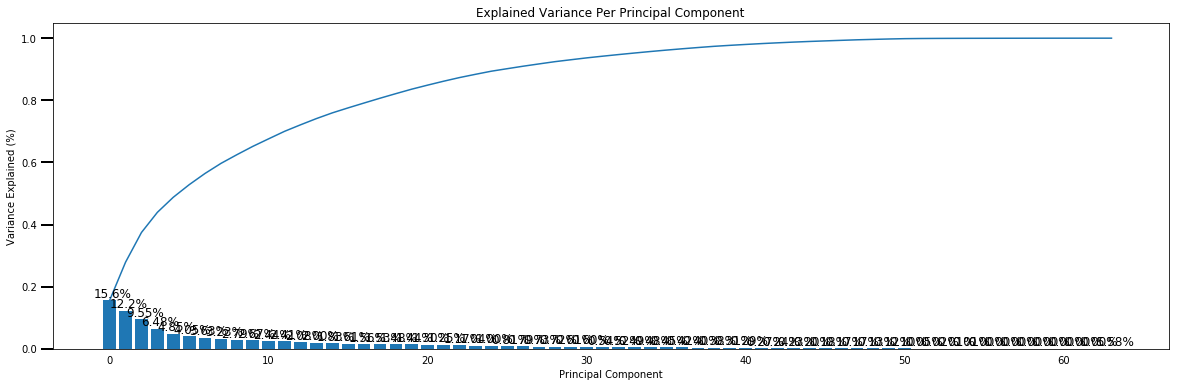

In [73]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [74]:
# Re-apply PCA to the data while selecting for number of components to retain.

# We can see that by using 45 components, the incremental variance explained variation ratio is near zero
pca = PCA(n_components=45)
azdias_scaled_select=pca.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

It was found that by using 45 components, the incremental variance explained variation ratio became almost zero. Therefore, we will keep those 45 component for the upcoming analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [75]:
# Find feature weights for component. Return list of features sorted in ascendent order of weight
def weights(component):
    weight_dict={}
    i = np.identity(azdias_scaled.shape[1]) 
    coef = pca.transform(i)
    j=0
    for col in azdias.columns:
        weight_dict.update({col: coef[j][component]})
        j = j + 1
    final = sorted(weight_dict, key=weight_dict.get)
    for element in final:
        print(element,weight_dict[element])

In [76]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

weights(0)

FINANZ_HAUSBAUER -0.102523681121
HH_EINKOMMEN_SCORE -0.0808174612488
SEMIO_LUST -0.0579878604962
WOHNDAUER_2008 -0.0480758379478
ANZ_HAUSHALTE_AKTIV -0.0383755335125
EWDICHTE -0.0363816009634
FINANZ_VORSORGER -0.0361934662805
ORTSGR_KLS9 -0.0356993991414
SEMIO_ERL -0.0327040269286
SEMIO_DOM -0.0296753682843
SEMIO_KAEM -0.021997838881
RELAT_AB -0.0215800095676
ARBEIT -0.0195112907643
ANREDE_KZ -0.0163453773342
ALTERSKATEGORIE_GROB -0.0126756088495
SEMIO_SOZ -0.0120332908199
OST_WEST_KZ_O -0.0119621687049
HEALTH_TYP -0.00930481825689
RETOURTYP_BK_S -0.00796378957142
W_KEIT_KIND_HH -0.00344318076483
ANZ_TITEL -0.000835163618243
SOHO_KZ 0.000840817581233
ANZ_HH_TITEL 0.00382693617738
SEMIO_KRIT 0.00607886848819
KBA13_ANZAHL_PKW 0.00673224135783
PRAEGENDE_JUGENDJAHRE_MOVEMENT 0.00783649919684
GREEN_AVANTGARDE 0.00925524685058
SEMIO_KULT 0.0113327714166
OST_WEST_KZ_W 0.0119621687049
ANZ_PERSONEN 0.0128675970457
SEMIO_PFLICHT 0.0177189976931
SEMIO_REL 0.0220174858998
FINANZ_SPARER 0.023849280

In [77]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights(1)

SEMIO_REL -0.301503764276
FINANZ_SPARER -0.283861530307
SEMIO_KULT -0.266386583159
SEMIO_PFLICHT -0.262919767036
PRAEGENDE_JUGENDJAHRE_DECADE -0.251952373478
SEMIO_TRADV -0.250642464995
SEMIO_FAM -0.237971791596
FINANZ_UNAUFFAELLIGER -0.229225444757
FINANZ_ANLEGER -0.202173250723
SEMIO_MAT -0.198763407572
SEMIO_RAT -0.181787271718
SEMIO_SOZ -0.148672538222
HH_EINKOMMEN_SCORE -0.0751479226716
SEMIO_VERT -0.073675664384
ONLINE_AFFINITAET -0.0354807567842
ORTSGR_KLS9 -0.0304199387462
EWDICHTE -0.027401126965
HEALTH_TYP -0.0264069845708
ANZ_HAUSHALTE_AKTIV -0.0256396543834
RELAT_AB -0.0167017533825
ARBEIT -0.0159809736548
CAMEO_INTL_2015_WEALTH -0.0117667746994
OST_WEST_KZ_O -0.0115280116138
W_KEIT_KIND_HH -0.00172175421227
SOHO_KZ -0.000264743847901
ANZ_PERSONEN 0.00128532631933
FINANZ_HAUSBAUER 0.0024446656927
ANZ_TITEL 0.00745793268154
PRAEGENDE_JUGENDJAHRE_MOVEMENT 0.00959532806069
REGIOTYP 0.00999193623753
OST_WEST_KZ_W 0.0115280116138
KKK 0.0115354631913
ANZ_HH_TITEL 0.0157144471081


In [78]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights(2)

ANREDE_KZ -0.350271430137
SEMIO_KAEM -0.338402301692
SEMIO_DOM -0.304927770834
SEMIO_KRIT -0.267627319331
SEMIO_RAT -0.234155065759
FINANZ_ANLEGER -0.187506260693
FINANZ_SPARER -0.150587927543
SEMIO_ERL -0.143812208183
FINANZ_HAUSBAUER -0.131628381744
HH_EINKOMMEN_SCORE -0.115927075039
FINANZ_UNAUFFAELLIGER -0.114663577261
SEMIO_PFLICHT -0.112952538745
PRAEGENDE_JUGENDJAHRE_DECADE -0.0986463056765
SEMIO_TRADV -0.0965713825255
HEALTH_TYP -0.0701394839075
ORTSGR_KLS9 -0.0541303055146
EWDICHTE -0.0525509503482
PRAEGENDE_JUGENDJAHRE_MOVEMENT -0.0472815507681
ANZ_HAUSHALTE_AKTIV -0.0469919670817
PLZ8_ANTG3 -0.0382474409184
PLZ8_ANTG4 -0.0356527640898
PLZ8_ANTG2 -0.0352469229924
PLZ8_HHZ -0.0315984540711
RELAT_AB -0.03128991523
CAMEO_INTL_2015_WEALTH -0.0307348828823
ARBEIT -0.0284153870513
PLZ8_GBZ -0.0222310087556
PLZ8_ANTG1 -0.0207398888474
W_KEIT_KIND_HH -0.0184279605142
OST_WEST_KZ_O -0.0136808022321
KBA05_ANTG3 -0.0120053798001
KBA05_ANTG4 -0.0102996575505
KBA05_ANTG2 -0.0088372470638


### Discussion 2.3: Interpret Principal Components

It could be observed that:
- The first component is heavily (positively) influenced by KBA05_ANTG3 KBA05_ANTG4 KBA05_ANTG2 KBA05_ANTG1 MOBI_REGIO KBA05_GBZ KBA05_GBZ → Micro-cell features and movement patterns
- The second component is heavily (negatively) influenced by SEMIO_REL FINANZ_SPARER SEMIO_KULT SEMIO_PFLICHT → Personality typology (religious or not, cultural-minded or not, dutiful or not) and Financial typology (money-saver or not)
- The third component is heavily(positively) influenced by ANREDE_KZ SEMIO_KAEM SEMIO_DOM SEMIO_KRIT SEMIO_RAT → Gender and Personality typology (combative or not, dominant or not, critical or not, rational or not)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [67]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [68]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
    
scores = []
centers = list(range(1,31))

for center in centers:
    print("Calculating for center #{}".format(center))
    scores.append(get_kmeans_score(azdias_scaled_select, center))

Calculating for center #1
Calculating for center #2
Calculating for center #3
Calculating for center #4
Calculating for center #5
Calculating for center #6
Calculating for center #7
Calculating for center #8
Calculating for center #9
Calculating for center #10
Calculating for center #11
Calculating for center #12
Calculating for center #13
Calculating for center #14
Calculating for center #15
Calculating for center #16
Calculating for center #17
Calculating for center #18
Calculating for center #19
Calculating for center #20
Calculating for center #21
Calculating for center #22
Calculating for center #23
Calculating for center #24
Calculating for center #25
Calculating for center #26
Calculating for center #27
Calculating for center #28
Calculating for center #29
Calculating for center #30


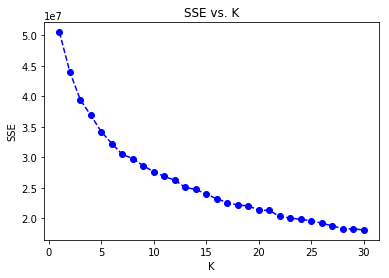

In [69]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [40]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Using the elbow's method, 12 clusters are selected
kmeans = KMeans(n_clusters=12)
model = kmeans.fit(azdias_scaled_select)
predictions_population = model.predict(azdias_scaled_select)

### Discussion 3.1: Apply Clustering to General Population

Based on the Score vs K graph, the number of clusters chosen was 12(elbow's method).

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [41]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')
rows_customers = customers.shape[0]
customers_clean = clean_data(customers)
nan_rows_customers = rows_customers-customers_clean.shape[0]

In [42]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_imputed = pd.DataFrame(fill_NaN.transform(customers_clean))
customers_imputed.columns = customers_clean.columns
customers_imputed.index = customers_clean.index
customers_scaled = scaler.transform(customers_imputed.values)
customers_scaled_select = pca.transform(customers_scaled)
predictions_customer = model.predict(customers_scaled_select)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [43]:
def plot_cluster(clust_dict):
    plt.figure(figsize=(20,6))
    plt.bar(clust_dict.keys(),clust_dict.values(), color='g')
    plt.show()

In [44]:
def dict_per(dict):
    sum = dict_sum(dict)
    dict_return = dict.copy()
    for e in dict_return.keys():
        dict_return[e] = 100*dict_return[e]/sum
    return dict_return

In [45]:
def dict_sum(dict):
    sum = 0
    for e in dict.values():
        sum = sum + e
    return sum

{10: 129776, 6: 212670, 4: 38926, 11: 116242, 7: 108511, 3: 26112, 2: 9404, 9: 13226, 0: 105331, 5: 32427, 8: 591, 1: 4210, 12: 93795}
{11: 65194, 6: 38119, 0: 17240, 3: 4034, 7: 2775, 4: 6462, 9: 614, 5: 1494, 10: 2858, 2: 884, 1: 566, 8: 31, 12: 51381}


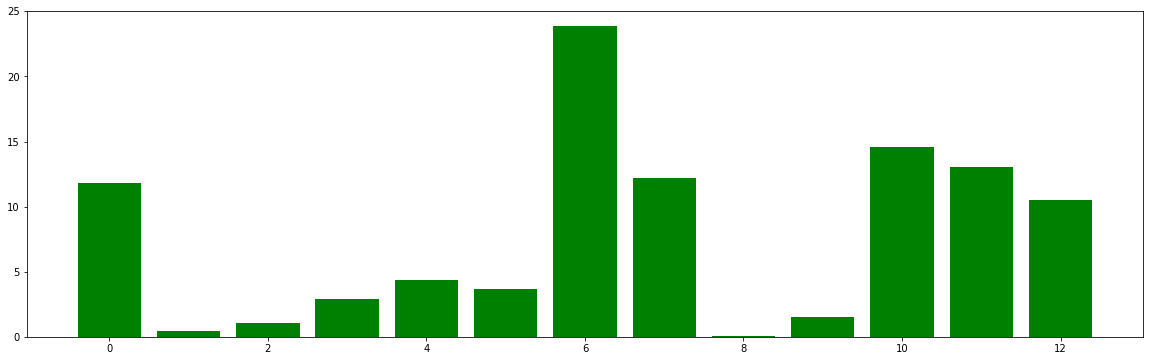

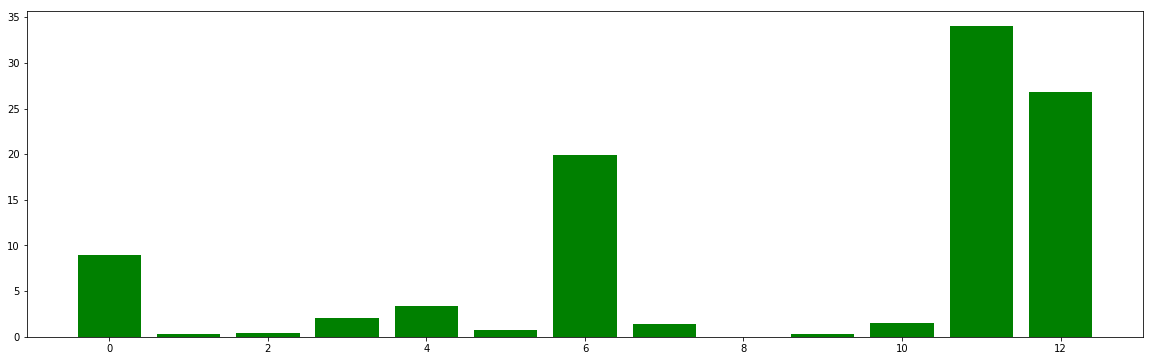

In [71]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#Counting number of data points per cluster
population_dict = dict(Counter(predictions_population))
customer_dict = dict(Counter(predictions_customer))

#Adding a cluster for the data points dropped in step 1.1.3
population_dict.update({len(population_dict):len(nan_list_row)})
customer_dict.update({len(population_dict)-1:nan_rows_customers})

#Printing number of data points per cluster
print(population_dict)
print(customer_dict)

#Percentage of data per cluster
population_dict_per = dict_per(population_dict)
customer_dict_per = dict_per(customer_dict)

#Plotting percentage of data per cluster
plot_cluster(population_dict_per)
plot_cluster(customer_dict_per)

In [72]:
def print_center_dict(center_dict):
    for e in center_dict:
        print("{} {}".format(e,center_dict[e]))

In [77]:
def create_center_dict(cluster):
    center = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[cluster]))
    center_dict = {}
    i=0
    for e in center:
        center_dict.update({azdias.columns[i]:e})
        i = i + 1
    return center_dict

In [78]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Calculate centroid for cluster #11 (this cluster has 35% representation in the 
# customer data but only 15% representation in the population data)
center_dict_11 = create_center_dict(11)

-	ALTERSKATEGORIE_GROB	3.413249095	age 30 - 45 years old/46 - 60 years old
-	ANREDE_KZ	1.056581671	gender male
-	FINANZ_MINIMALIST	4.636433264	low financial interest average/low
-	FINANZ_SPARER	1.754140997	money-saver very high/high
-	FINANZ_VORSORGER	4.170584956	be prepared low
-	FINANZ_ANLEGER	1.907603766	investor high
-	FINANZ_UNAUFFAELLIGER	1.995018278	inconspicuous high
-	FINANZ_HAUSBAUER	1.966159612	home ownership high
-	GREEN_AVANTGARDE	0.441111973	not a member of green avantgarde
-	HEALTH_TYP	2.579539703	sanitary affine / jaunty hedonists
-	RETOURTYP_BK_S	4.330332001	conservative Low-Returner
-	SEMIO_SOZ	4.830835193	socially-minded average affinity/ low affinity
-	SEMIO_FAM	4.543486461	family-minded average affinity/low affinity
-	SEMIO_REL	3.762080955	religious high affinity/average affinity
-	SEMIO_MAT	3.304032868	materialistic high affinity
-	SEMIO_VERT	5.970617137	dreamful very low affinity
-	SEMIO_LUST	5.10814603	sensual-minded low affinity
-	SEMIO_ERL	4.210504285	event-oriented average affinity
-	SEMIO_KULT	5.05854446	cultural-minded low affinity
-	SEMIO_RAT	2.714429057	rational very high affinity/high affinity
-	SEMIO_KRIT	3.409814246	critical-minded high affinity/average affinity
-	SEMIO_DOM	3.499119944	dominant-minded high affinity/average affinity
-	SEMIO_KAEM	2.561188261	combative attitude very high affinity/high affinity
-	SEMIO_PFLICHT	3.087840264	dutiful high affinity
-	SEMIO_TRADV	3.12127373	tradional-minded high affinity
-	SOHO_KZ	0.009558471	no small office/home office
-	ANZ_PERSONEN	2.096473996	2 adults in household
-	ANZ_TITEL	0.006468851	0 professional academic title holders in household
-	HH_EINKOMMEN_SCORE	3.246102844	high income
-	W_KEIT_KIND_HH	5.56042298	Likelihood of children in household unlikely/very unlikely
-	WOHNDAUER_2008	8.463106632	length of residence 7-10 years/more than 10 years
-	ANZ_HAUSHALTE_AKTIV	2.803805217	3 households in the building
-	ANZ_HH_TITEL	0.557264649	0/1 professional academic title holders in building
-	KONSUMNAEHE	3.806909535	building is located in a 1 x 1km grid cell that includes at least one RA1-consumption cell
-	MIN_GEBAEUDEJAHR	1992.730517	year building was mentioned in the database
-	KBA05_ANTG1	2.524173359	average share of 1-2 family homes/high share of 1-2 family homes
-	KBA05_ANTG2	1.183942899	lower share of 3-5 family homes
-	KBA05_ANTG3	0.218280351	no 6-10 family homes
-	KBA05_ANTG4	0.064927471	no 10+ family homes
-	KBA05_GBZ	4.02047444	17-22 buildings
-	BALLRAUM	4.87482658	Distance to nearest urban center 40 -  50 km
-	EWDICHTE	3.077158397	 90 - 149 households per km^2
-	INNENSTADT	5.454112471	10 - 20 km to city center/20 - 30 km to city center
-	GEBAEUDETYP_RASTER	4.070528958	mixed cell with low business share
-	KKK	2.655129149	high/average
-	MOBI_REGIO	4.04310608	low movement
-	ONLINE_AFFINITAET	3.346629365	high/very high
-	REGIOTYP	4.06969839	Neighborhood middle class
-	KBA13_ANZAHL_PKW	686.3316102	686 cars in the PLZ8 region
-	PLZ8_ANTG1	2.839579213	average share of 1-2 family homes/high share of 1-2 family homes
-	PLZ8_ANTG2	2.433457256	average share of 3-5 family homes/high share of 3-5 family homes
-	PLZ8_ANTG3	1.001637776	lower share of 6-10 family homes
-	PLZ8_ANTG4	0.272881644	no 10+ family homes
-	PLZ8_HHZ	3.491535941	300-599 households/600-849 households
-	PLZ8_GBZ	3.854205405	300-449 buildings/130-299 buildings
-	ARBEIT	2.752010121	Share of unemployment in community average/low
-	ORTSGR_KLS9	4.109492169	Size of community 10,001 to  20,000 inhabitants
-	RELAT_AB	2.604052958	Share of unemployment relative to county in which community is contained average/low
-	OST_WEST_KZ_O	0.117534678	Not from east germany
-	OST_WEST_KZ_W	0.882465322	from west germany
-	PRAEGENDE_JUGENDJAHRE_DECADE	66.37129697	Decade 60/70
-	PRAEGENDE_JUGENDJAHRE_MOVEMENT	0.614420573	Movement Avantgarde
-	CAMEO_INTL_2015_WEALTH	2.597711018	Comfortable Households
-	CAMEO_INTL_2015_LIFE_STAGE	3.595597601	Older Families &  Mature Couples/Families With School Age Children


In [80]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Calculate centroid for cluster #10(this cluster has 15% representation in the 
# population data but less than 5% representation in the customer data)
center_dict_10 = create_center_dict(10)

-	ALTERSKATEGORIE_GROB	1.631263908	age < 30 years old/30 - 45 years old
-	ANREDE_KZ	2.006875639	gender female
-	FINANZ_MINIMALIST	1.72653559	low financial interest very high/high
-	FINANZ_SPARER	4.067882833	money-saver low
-	FINANZ_VORSORGER	2.199319085	be prepared high
-	FINANZ_ANLEGER	4.141112044	investor low
-	FINANZ_UNAUFFAELLIGER	3.756023151	inconspicuous average/low
-	FINANZ_HAUSBAUER	3.587397327	home ownership average/low
-	GREEN_AVANTGARDE	0.127167866	not a member of green avantgarde
-	HEALTH_TYP	2.214626179	sanitary affine  
-	RETOURTYP_BK_S	2.655915968	demanding Heavy-Returner/incentive-receptive Normal-Returner
-	SEMIO_SOZ	2.970047132	socially-minded high affinity
-	SEMIO_FAM	3.773792231	family-minded high affinity/average affinity
-	SEMIO_REL	5.362076132	religious low affinity
-	SEMIO_MAT	4.936684881	materialistic low affinity
-	SEMIO_VERT	2.286321171	dreamful very high affinity
-	SEMIO_LUST	2.827716111	sensual-minded high affinity
-	SEMIO_ERL	4.120311155	event-oriented average affinity
-	SEMIO_KULT	4.214922044	cultural-minded average affinity
-	SEMIO_RAT	6.450145353	rational very low affinity/lowest affinity
-	SEMIO_KRIT	5.457251907	critical-minded low affinity/very low affinity
-	SEMIO_DOM	6.29692797	dominant-minded very low affinity
-	SEMIO_KAEM	5.877945948	combative attitude low affinity/very low affinity
-	SEMIO_PFLICHT	6.173448268	dutiful very low affinity
-	SEMIO_TRADV	6.259928064	tradional-minded very low affinity
-	SOHO_KZ	0.008432122	no small office/home office
-	ANZ_PERSONEN	1.708493147	1/2 adults in household
-	ANZ_TITEL	0.002001289	0 professional academic title holders in household
-	HH_EINKOMMEN_SCORE	4.913337487	lower income
-	W_KEIT_KIND_HH	5.556542593	Likelihood of children in household unlikely/very unlikely
-	WOHNDAUER_2008	7.407000481	length of residence 6-7 years/7-10 years
-	ANZ_HAUSHALTE_AKTIV	9.425577505	9/10 households in the building
-	ANZ_HH_TITEL	0.110827149	0 professional academic title holders in building
-	KONSUMNAEHE	2.848778544	building is located in a 500 x 500m grid cell that includes at least one RA1-consumption cell
-	MIN_GEBAEUDEJAHR	1992.527475	year building was mentioned in the database
-	KBA05_ANTG1	1.292729259	lower share of 1-2 family homes/average share of 1-2 family homes
-	KBA05_ANTG2	1.360049739	lower share of 3-5 family homes/average share of 3-5 family homes
-	KBA05_ANTG3	0.72125291	no 6-10 family homes/lower share of 6-10 family homes
-	KBA05_ANTG4	0.344672496	no 10+ family homes/lower share of 10+ family homes
-	KBA05_GBZ	2.998731112	5-16 buildings
-	BALLRAUM	3.992232072	Distance to nearest urban center 30 -  40 km
-	EWDICHTE	4.152715726	150 - 319 households per km^2
-	INNENSTADT	4.349498393	5 - 10 km to city center/10 - 20 km to city center
-	GEBAEUDETYP_RASTER	3.677129997	 mixed cell with middle business share/ mixed cell with low business share
-	KKK	2.860338402	average/high
-	MOBI_REGIO	2.7500006	middle movement/high movement
-	ONLINE_AFFINITAET	3.448314298	high/very high
-	REGIOTYP	4.59713041	Neighborhood middle class/lower middle class
-	KBA13_ANZAHL_PKW	601.7155165	601 cars in the PLZ8 region
-	PLZ8_ANTG1	2.14174601	average share of 1-2 family homes
-	PLZ8_ANTG2	2.889117656	high share of 3-5 family homes/average share of 3-5 family homes
-	PLZ8_ANTG3	1.715436476	average share of 6-10 family homes/lower share of 6-10 family homes
-	PLZ8_ANTG4	0.778851724	lower share of 10+ family homes/no 10+ family homes
-	PLZ8_HHZ	3.643896708	600-849 households/300-599 households
-	PLZ8_GBZ	3.297044452	130-299 buildings
-	ARBEIT	3.255039484	Share of unemployment in community average
-	ORTSGR_KLS9	5.577375716	Size of community 20,001 to  50,000 inhabitants/50,001 to 100,000 inhabitants
-	RELAT_AB	3.157032947	Share of unemployment relative to county in which community is contained average
-	OST_WEST_KZ_O	0.215990617	Not from east germany
-	OST_WEST_KZ_W	0.784009383	from west germany
-	PRAEGENDE_JUGENDJAHRE_DECADE	86.08376904	Decade 80/90
-	PRAEGENDE_JUGENDJAHRE_MOVEMENT	0.139258233	Movement Mainstream
-	CAMEO_INTL_2015_WEALTH	3.700968134	Comfortable Households/Less Affluent Households
-	CAMEO_INTL_2015_LIFE_STAGE	2.847298771	Families With School Age Children/Young Couples With Children


### Discussion 3.3: Compare Customer Data to Demographics Data

Based on the clustering analysis, we can say that:
- Relatively popular:
We can see that this population is represented by cluster #11. This cluster represents people(males) born in the 60's 70's(from 30 to 60 years old), originally from west germany. Wealth: comfortable households, life stage: older families & mature couples. They own their own house and have interest in finance and investing. They are conservative/traditional and dreamful affinity is low.
- Relatively unpopular:
We can see that this population is represented by cluster #10. This cluster represents people(females) born in the 80's 90's(less than 45 years old), originally from west germany. Wealth: less affluent households, life stage: families with achool age children. They don't own their own house and don't have interest in finance/investing. They are not religious/traditional and dreamful affinity is very-high. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.